In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 15 11:01:32 2022

@author: Simone
"""

import numpy as np 
import pandas as pd 
from IPython.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN,KMeans
from sklearn.preprocessing import StandardScaler
import pyproj
import json
from shapely.geometry import Point, mapping
from functools import partial
from shapely.ops import transform
from mpl_toolkits.mplot3d import proj3d
from scipy.spatial.distance import cdist
import seaborn as sns


%matplotlib notebook
df = pd.read_csv("New/datasetItalyComplete.csv", dtype = {"ITTER107":str})
df = df.loc[df['Sesso'] != "totale"]
df = df.loc[df['Stato civile'] != "totale"]

In [2]:
df['populPerKm2'] = df['Value']/df['Size km2']
df = df.loc[df['populPerKm2'] > 10]#Filter out small villages
df = df.reset_index().drop(["index"],axis =1)#.to_csv("datasetItalyCompleteNoSmallVill.csv", encoding='utf-8',index=False)
df

,Territorio,Sesso,Stato civile,AgeGroup,Value,lat,lng,Size km2,Redditi 2020,AvgNumberOfComponents,ITTER107,populPerKm2
0,Abano Terme,femmine,coniugata/o,30s,447,45.359387,11.788713,21.57,20753.0,2.22,28001.0,20.723227
1,Abano Terme,femmine,coniugata/o,40s,890,45.359387,11.788713,21.57,20753.0,2.22,28001.0,41.261011
2,Abano Terme,femmine,coniugata/o,50s,1126,45.359387,11.788713,21.57,20753.0,2.22,28001.0,52.202133
3,Abano Terme,femmine,coniugata/o,60s,1049,45.359387,11.788713,21.57,20753.0,2.22,28001.0,48.632360
4,Abano Terme,femmine,coniugata/o,70s,714,45.359387,11.788713,21.57,20753.0,2.22,28001.0,33.101530
...,...,...,...,...,...,...,...,...,...,...,...,...
50945,Zumpano,maschi,coniugata/o,60s,112,39.310632,16.293506,8.06,11036.0,2.54,78155.0,13.895782
50946,Zumpano,maschi,nubile/celibe,Kid,163,39.310632,16.293506,8.06,11036.0,2.54,78155.0,20.223325
50947,Zumpano,maschi,nubile/celibe,Teen,121,39.310632,16.293506,8.06,11036.0,2.54,78155.0,15.012407
50948,Zumpano,maschi,nubile/celibe,20s,129,39.310632,16.293506,8.06,11036.0,2.54,78155.0,16.004963


## Get only Lombardy

In [3]:
# lombardy = pd.read_excel('New/Elenco-comuni-italiani.xls', sheet_name=0) #reads the first sheet of your excel file
# lombardy = lombardy[lombardy['Denominazione Regione']=='Lombardia'] #Filtering dataframe
# df["ITTER107"] = pd.to_numeric(df["ITTER107"])
# df = pd.merge(df, lombardy,how='inner',left_on=['ITTER107'],right_on=['Codice Comune formato alfanumerico'])
# df.drop(lombardy.columns,axis = 1, inplace = True)
# df

In [4]:

# heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [5]:
dfSliced = df[['lng','lat','Sesso','Stato civile','AgeGroup','AvgNumberOfComponents','Redditi 2020']]
catColumnsPos = [dfSliced.columns.get_loc(col) for col in list(dfSliced.select_dtypes('object').columns)]
catColumnsPos += [dfSliced.columns.get_loc(col) for col in list(dfSliced.select_dtypes('category').columns)]

In [6]:
#No if kprot
dfSlicedNoCat = pd.get_dummies(dfSliced)
dfSlicedNoCat.describe()

,lng,lat,AvgNumberOfComponents,Redditi 2020,Sesso_femmine,Sesso_maschi,Stato civile_coniugata/o,Stato civile_divorziata/o,Stato civile_nubile/celibe,Stato civile_vedova/o,...,AgeGroup_30s,AgeGroup_40s,AgeGroup_50s,AgeGroup_60s,AgeGroup_70s,AgeGroup_80s,AgeGroup_90s,AgeGroup_Infant,AgeGroup_Kid,AgeGroup_Teen
count,50950.000000,50950.000000,50950.000000,50950.000000,50950.000000,50950.000000,50950.000000,50950.000000,50950.000000,50950.000000,...,50950.000000,50950.000000,50950.000000,50950.000000,50950.000000,50950.000000,50950.000000,50950.000000,50950.000000,50950.000000
mean,11.353424,43.819661,2.392884,18357.597978,0.510893,0.489107,0.486516,0.014485,0.436820,0.062179,...,0.125692,0.153719,0.150697,0.116683,0.097939,0.056546,0.005535,0.024141,0.093405,0.075074
std,2.662191,2.498323,0.204700,3865.324100,0.499886,0.499886,0.499823,0.119479,0.495997,0.241482,...,0.331505,0.360683,0.357757,0.321045,0.297235,0.230975,0.074191,0.153489,0.291002,0.263513
min,7.046420,35.501955,1.630000,7631.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.198760,41.557748,2.280000,15757.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,10.538235,45.312214,2.380000,18984.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,13.656463,45.651065,2.490000,20900.250000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,18.453989,46.897972,3.120000,43674.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Normalize

In [7]:
# from sklearn import preprocessing
# x = dfSliced[["AvgNumberOfComponents","Redditi 2020"]].values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# dfSliced[["AvgNumberOfComponents","Redditi 2020"]] = pd.DataFrame(
#     x_scaled,columns=dfSliced[["AvgNumberOfComponents","Redditi 2020"]].columns,)

### Standardize

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dfSlicedNoCat[["AvgNumberOfComponents","Redditi 2020"]].values)
scaled_features_df = pd.DataFrame(scaled_features, 
                                  index=dfSlicedNoCat[["AvgNumberOfComponents","Redditi 2020"]].index, 
                                  columns=dfSlicedNoCat[["AvgNumberOfComponents","Redditi 2020"]].columns)
dfSlicedNoCat[["AvgNumberOfComponents","Redditi 2020"]] = scaled_features_df

scaler = StandardScaler()
scaled_features = scaler.fit_transform(dfSliced[["AvgNumberOfComponents","Redditi 2020"]].values)
scaled_features_df = pd.DataFrame(scaled_features, 
                                  index=dfSliced[["AvgNumberOfComponents","Redditi 2020"]].index, 
                                  columns=dfSliced[["AvgNumberOfComponents","Redditi 2020"]].columns)
dfSliced[["AvgNumberOfComponents","Redditi 2020"]] = scaled_features_df

C:\Users\sarat\AppData\Local\Temp\ipykernel_3528\3968700852.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfSliced[["AvgNumberOfComponents","Redditi 2020"]] = scaled_features_df


In [9]:
dfSlicedNoCat

,lng,lat,AvgNumberOfComponents,Redditi 2020,Sesso_femmine,Sesso_maschi,Stato civile_coniugata/o,Stato civile_divorziata/o,Stato civile_nubile/celibe,Stato civile_vedova/o,...,AgeGroup_30s,AgeGroup_40s,AgeGroup_50s,AgeGroup_60s,AgeGroup_70s,AgeGroup_80s,AgeGroup_90s,AgeGroup_Infant,AgeGroup_Kid,AgeGroup_Teen
0,11.788713,45.359387,-0.844582,0.619722,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,11.788713,45.359387,-0.844582,0.619722,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,11.788713,45.359387,-0.844582,0.619722,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,11.788713,45.359387,-0.844582,0.619722,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,11.788713,45.359387,-0.844582,0.619722,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50945,16.293506,39.310632,0.718697,-1.894193,0,1,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
50946,16.293506,39.310632,0.718697,-1.894193,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
50947,16.293506,39.310632,0.718697,-1.894193,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
50948,16.293506,39.310632,0.718697,-1.894193,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
dfSliced

,lng,lat,Sesso,Stato civile,AgeGroup,AvgNumberOfComponents,Redditi 2020
0,11.788713,45.359387,femmine,coniugata/o,30s,-0.844582,0.619722
1,11.788713,45.359387,femmine,coniugata/o,40s,-0.844582,0.619722
2,11.788713,45.359387,femmine,coniugata/o,50s,-0.844582,0.619722
3,11.788713,45.359387,femmine,coniugata/o,60s,-0.844582,0.619722
4,11.788713,45.359387,femmine,coniugata/o,70s,-0.844582,0.619722
...,...,...,...,...,...,...,...
50945,16.293506,39.310632,maschi,coniugata/o,60s,0.718697,-1.894193
50946,16.293506,39.310632,maschi,nubile/celibe,Kid,0.718697,-1.894193
50947,16.293506,39.310632,maschi,nubile/celibe,Teen,0.718697,-1.894193
50948,16.293506,39.310632,maschi,nubile/celibe,20s,0.718697,-1.894193


In [11]:
# import seaborn as sns

# heatmap = sns.heatmap(dfSlicedNoCat.corr(), vmin=-1, vmax=1, annot=True)
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

## Elbow KMeans


In [12]:
# # Choose optimal K using Elbow method
# distortions = []
# inertias = []

# rangeCl = range(10, 100)

# print(catColumnsPos)
# for cluster in rangeCl:
#     kmeans = KMeans( n_clusters = cluster, init = 'k-means++', random_state = 0)
#     categories = kmeans.fit_predict(dfSlicedNoCat)
#     distortions.append(sum(np.min(cdist(dfSlicedNoCat, kmeans.cluster_centers_,
#                                         'euclidean'), axis=1)) / dfSlicedNoCat.shape[0])
#     inertias.append(kmeans.inertia_)
#     print('Cluster initiation: {}'.format(cluster))

In [13]:
# #Data viz

# plt.plot(rangeCl, inertias, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Inertia')
# plt.title('The Elbow Method using Inertia')
# plt.show()

In [14]:
# plt.plot(rangeCl, distortions, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method using Distortion')
# plt.show()

### Clustering KMeans

In [11]:
nClusters = 170 #88 Lombardy #170 Italy #250 too many low silh

kmeans = KMeans( n_clusters = nClusters, init = 'k-means++', random_state = 0)
kMeansCategories = kmeans.fit_predict(dfSlicedNoCat)
df["cluster"] = kMeansCategories

In [18]:
# df#.to_csv("clusteringItalia.csv", encoding='utf-8',index=False)

,Territorio,Sesso,Stato civile,AgeGroup,Value,lat,lng,Size km2,Redditi 2020,AvgNumberOfComponents,ITTER107,populPerKm2,cluster
0,Abano Terme,femmine,coniugata/o,30s,447,45.359387,11.788713,21.57,20753.0,2.22,28001.0,20.723227,108
1,Abano Terme,femmine,coniugata/o,40s,890,45.359387,11.788713,21.57,20753.0,2.22,28001.0,41.261011,95
2,Abano Terme,femmine,coniugata/o,50s,1126,45.359387,11.788713,21.57,20753.0,2.22,28001.0,52.202133,95
3,Abano Terme,femmine,coniugata/o,60s,1049,45.359387,11.788713,21.57,20753.0,2.22,28001.0,48.632360,39
4,Abano Terme,femmine,coniugata/o,70s,714,45.359387,11.788713,21.57,20753.0,2.22,28001.0,33.101530,95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50945,Zumpano,maschi,coniugata/o,60s,112,39.310632,16.293506,8.06,11036.0,2.54,78155.0,13.895782,10
50946,Zumpano,maschi,nubile/celibe,Kid,163,39.310632,16.293506,8.06,11036.0,2.54,78155.0,20.223325,72
50947,Zumpano,maschi,nubile/celibe,Teen,121,39.310632,16.293506,8.06,11036.0,2.54,78155.0,15.012407,72
50948,Zumpano,maschi,nubile/celibe,20s,129,39.310632,16.293506,8.06,11036.0,2.54,78155.0,16.004963,72


## Elbow KPrototypes

In [16]:
# #Choose optimal K using Elbow method
# cost = []


# print(catColumnsPos)
# for cluster in range(60, 86):
#     try:
#         kprototype = KPrototypes(n_jobs = -1, n_clusters = cluster, init = 'Huang', random_state = 0)
#         kprototype.fit_predict(dfSliced, categorical = catColumnsPos)
#         cost.append(kprototype.cost_)
#         print('Cluster initiation: {}'.format(cluster))
#     except:
#         break
# # Converting the results into a dataframe and plotting them
# #Data viz

# plt.plot( range(60, 86), cost, 'bx-')
# plt.xlabel('Values of K')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method using Distortion')
# plt.show()
# plt.savefig('elbow.png', dpi=fig.dpi)

### Clustering KPrototype

In [11]:
from kmodes.kprototypes import KPrototypes

nClusters = 4 #40

catColumnsPos = [dfSliced.columns.get_loc(col) for col in list(dfSliced.select_dtypes('object').columns)]
catColumnsPos += [dfSliced.columns.get_loc(col) for col in list(dfSliced.select_dtypes('category').columns)]
kprototype = KPrototypes(n_jobs = -1, n_clusters = nClusters, init = 'Huang', random_state = 0)
KProtcategories = kprototype.fit_predict(dfSliced, categorical = catColumnsPos)
df["cluster"] = KProtcategories


## SOM

In [ ]:
# from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
# from minisom import MiniSom
# # Setting some parameters in advance
# x = y = 10
# input_len = dfSlicedNoCat.shape[1]
# sigma = 1.0
# learning_rate = 0.5
# iterations = 1000

# space = {
#     'sig': hp.uniform('sig',0.001,5.0),
#     'learning_rate': hp.uniform('learning_rate',0.001,1),
#     'x' :  hp.uniform('x',10,100),
#     'y' :  hp.uniform('y',10,100)
# }

# def opt_map(space):
#     sig = space['sig']
#     learning_rate = space['learning_rate']
#     x = space['x']
#     y = space['y']
#     val = MiniSom(x=int(x), y=int(y), input_len=input_len, sigma=sigma, learning_rate=learning_rate).quantization_error(dfSlicedNoCat.values)
#     #print("Now,the quantization error is {}\n".format(val))
#     return {'loss':val, 'status':STATUS_OK}

# trials = Trials()
# best_params = fmin(fn=opt_map,space=space,algo=tpe.suggest,max_evals=10,trials=trials)
# print("The best sigma value after 50 iterations is {}".format(best_params['sig']))
# print("The best learning_rate after 50 iterations is {}".format(best_params['learning_rate']))
# print("The best x after 50 iterations is {}".format(int(best_params['x'])))
# print("The best y after 50 iterations is {}".format(int(best_params['y'])))

In [ ]:
# from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
# from minisom import MiniSom
# # Setting some parameters in advance
# x = y = 10
# input_len = dfSlicedNoCat.shape[1]
# sigma = 1.0
# learning_rate = 0.5
# iterations = 1000

# space = {
#     'sig': hp.uniform('sig',0.001,5.0),
#     'learning_rate': hp.uniform('learning_rate',0.001,1),
#     'x' :  hp.uniform('x',10,100),
#     'y' :  hp.uniform('y',10,100)
# }

# def opt_map(space):
#     sig = space['sig']
#     learning_rate = space['learning_rate']
#     x = space['x']
#     y = space['y']
#     som = MiniSom(x=int(x), y=int(y), input_len=input_len, sigma=sigma, 
#                   learning_rate=learning_rate)
#     som.train_batch(dfSlicedNoCat.values, 10000)
#     winner_coordinates = np.array([som.winner(x) for x in dfSlicedNoCat.values]).T
#     # with np.ravel_multi_index we convert the bidimensional
#     # coordinates to a monodimensional index
#     SOMCategories = np.ravel_multi_index(winner_coordinates, (int(x),int(y)))
#     val = -silhouette_score(dfSlicedNoCat,SOMCategories,sample_size = int(len(dfSlicedNoCat)/5),random_state = 0)
#     #print("Now,the quantization error is {}\n".format(val))
#     return {'loss':val, 'status':STATUS_OK}

# trials = Trials()
# best_params = fmin(fn=opt_map,space=space,algo=tpe.suggest,max_evals=10,trials=trials)
# print("The best sigma value after 50 iterations is {}".format(best_params['sig']))
# print("The best learning_rate after 50 iterations is {}".format(best_params['learning_rate']))
# print("The best x after 50 iterations is {}".format(int(best_params['x'])))
# print("The best y after 50 iterations is {}".format(int(best_params['y'])))

In [17]:
from minisom import MiniSom

# With quantization_error
som_shape = (41,42)
lr = 0.9310156988049898
sig = 1.590577785080987

# With topographic error
# som_shape = (35,10)
# lr = 0.19228430625877874
# sig = 2.0404878138221725

# With silhouette
# som_shape = (61,33)
# lr = 0.4207120861264718
# sig = 4.443618124736826

# With silhouette more iterations
# som_shape = (14,91)
# lr = 0.45328188042355616
# sig = 2.0044976649797683

som = MiniSom(x=som_shape[0], y=som_shape[1], input_len=dfSlicedNoCat.shape[1], learning_rate = lr, sigma = sig)
som.train_batch(dfSlicedNoCat.values, 100000,  verbose=True)
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in dfSlicedNoCat.values]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
SOMCategories = np.ravel_multi_index(winner_coordinates, som_shape)
df["cluster"] = SOMCategories
nClusters = max(SOMCategories)

 [    346 / 100000 ]   0% - 0:00:53 left 

 [    645 / 100000 ]   1% - 0:00:57 left 

 [    957 / 100000 ]   1% - 0:00:58 left 

 [   1293 / 100000 ]   1% - 0:00:57 left 

 [   1604 / 100000 ]   2% - 0:00:58 left 

 [   1844 / 100000 ]   2% - 0:00:59 left 

 [   2181 / 100000 ]   2% - 0:00:59 left 

 [   2475 / 100000 ]   2% - 0:00:59 left 

 [   2787 / 100000 ]   3% - 0:00:59 left 

 [   3070 / 100000 ]   3% - 0:00:59 left 

 [   3376 / 100000 ]   3% - 0:00:59 left 

 [   3680 / 100000 ]   4% - 0:00:59 left 

 [   3962 / 100000 ]   4% - 0:00:59 left 

 [   4255 / 100000 ]   4% - 0:00:59 left 

 [   4542 / 100000 ]   5% - 0:00:59 left 

 [   4879 / 100000 ]   5% - 0:00:58 left 

 [   5222 / 100000 ]   5% - 0:00:57 left 

 [   5559 / 100000 ]   6% - 0:00:57 left 

 [   5875 / 100000 ]   6% - 0:00:57 left 

 [   6187 / 100000 ]   6% - 0:00:56 left 

 [   6510 / 100000 ]   7% - 0:00:56 left 

 [   6800 / 100000 ]   7% - 0:00:56 left 

 [   7114 / 100000 ]   7% - 0:00:56 left 

 [   7422 / 100000 ]   7% - 0:00:56 left 

 [   7725 / 100000 ]   8% - 0:00:56 left 

 [   8043 / 100000 ]   8% - 0:00:55 left 

 [   8352 / 100000 ]   8% - 0:00:55 left 

 [   8677 / 100000 ]   9% - 0:00:55 left 

 [   8930 / 100000 ]   9% - 0:00:55 left 

 [   9216 / 100000 ]   9% - 0:00:55 left 

 [   9531 / 100000 ]  10% - 0:00:55 left 

 [   9848 / 100000 ]  10% - 0:00:55 left 

 [  10139 / 100000 ]  10% - 0:00:54 left 

 [  10413 / 100000 ]  10% - 0:00:54 left 

 [  10691 / 100000 ]  11% - 0:00:54 left 

 [  11015 / 100000 ]  11% - 0:00:54 left 

 [  11338 / 100000 ]  11% - 0:00:54 left 

 [  11637 / 100000 ]  12% - 0:00:54 left 

 [  11918 / 100000 ]  12% - 0:00:54 left 

 [  12270 / 100000 ]  12% - 0:00:53 left 

 [  12610 / 100000 ]  13% - 0:00:53 left 

 [  12916 / 100000 ]  13% - 0:00:53 left 

 [  13213 / 100000 ]  13% - 0:00:52 left 

 [  13491 / 100000 ]  13% - 0:00:52 left 

 [  13775 / 100000 ]  14% - 0:00:52 left 

 [  14064 / 100000 ]  14% - 0:00:52 left 

 [  14387 / 100000 ]  14% - 0:00:52 left 

 [  14694 / 100000 ]  15% - 0:00:52 left 

 [  14940 / 100000 ]  15% - 0:00:52 left 

 [  15231 / 100000 ]  15% - 0:00:52 left 

 [  15519 / 100000 ]  16% - 0:00:52 left 

 [  15825 / 100000 ]  16% - 0:00:51 left 

 [  16120 / 100000 ]  16% - 0:00:51 left 

 [  16454 / 100000 ]  16% - 0:00:51 left 

 [  16731 / 100000 ]  17% - 0:00:51 left 

 [  17022 / 100000 ]  17% - 0:00:51 left 

 [  17308 / 100000 ]  17% - 0:00:51 left 

 [  17605 / 100000 ]  18% - 0:00:50 left 

 [  17930 / 100000 ]  18% - 0:00:50 left 

 [  18299 / 100000 ]  18% - 0:00:50 left 

 [  18652 / 100000 ]  19% - 0:00:49 left 

 [  18902 / 100000 ]  19% - 0:00:49 left 

 [  19248 / 100000 ]  19% - 0:00:49 left 

 [  19566 / 100000 ]  20% - 0:00:49 left 

 [  19843 / 100000 ]  20% - 0:00:49 left 

 [  20100 / 100000 ]  20% - 0:00:49 left 

 [  20349 / 100000 ]  20% - 0:00:49 left 

 [  20602 / 100000 ]  21% - 0:00:49 left 

 [  20868 / 100000 ]  21% - 0:00:49 left 

 [  21106 / 100000 ]  21% - 0:00:49 left 

 [  21410 / 100000 ]  21% - 0:00:48 left 

 [  21744 / 100000 ]  22% - 0:00:48 left 

 [  22015 / 100000 ]  22% - 0:00:48 left 

 [  22309 / 100000 ]  22% - 0:00:48 left 

 [  22610 / 100000 ]  23% - 0:00:48 left 

 [  22864 / 100000 ]  23% - 0:00:48 left 

 [  23187 / 100000 ]  23% - 0:00:47 left 

 [  23518 / 100000 ]  24% - 0:00:47 left 

 [  23782 / 100000 ]  24% - 0:00:47 left 

 [  24039 / 100000 ]  24% - 0:00:47 left 

 [  24340 / 100000 ]  24% - 0:00:47 left 

 [  24618 / 100000 ]  25% - 0:00:47 left 

 [  24960 / 100000 ]  25% - 0:00:46 left 

 [  25233 / 100000 ]  25% - 0:00:46 left 

 [  25530 / 100000 ]  26% - 0:00:46 left 

 [  25818 / 100000 ]  26% - 0:00:46 left 

 [  26069 / 100000 ]  26% - 0:00:46 left 

 [  26272 / 100000 ]  26% - 0:00:46 left 

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.9257792687995243


In [18]:
from sklearn.metrics.cluster import silhouette_score

silhouette_score(dfSlicedNoCat,SOMCategories,sample_size = int(len(dfSlicedNoCat)/5),random_state = 0)


0.09497765590779078

## Fuzzy C-Means

In [ ]:
from pyclustering.cluster.fcm import fcm
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from sklearn.metrics.cluster import silhouette_score

# Choose optimal K using Elbow method
silhouette = []

rangeCl = range(10, 12)

for cluster in rangeCl:
    initial_centers = kmeans_plusplus_initializer(dfSlicedNoCat, cluster, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
    fcm_instance = fcm(dfSlicedNoCat.values, initial_centers)
    fcm_instance.process()
    clusters = fcm_instance.get_clusters()
    df["cluster"] = 1
    i=0
    for c in clusters:
        df.iloc[c,df.columns.get_loc('cluster')] =i
        i = i+1
    FCMCategories = df["cluster"].values
    
    silhouette.append(silhouette_score(dfSlicedNoCat,FCMCategories,
                                               sample_size = int(len(dfSlicedNoCat)/5),random_state = 0))
    print('Cluster initiation: {}'.format(cluster))
#Data viz

plt.plot(rangeCl, silhouette, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('The Elbow Method using Silhouette')
plt.show()

In [ ]:
from pyclustering.cluster.fcm import fcm
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

amount_initial_centers = 170

# initialize
initial_centers = kmeans_plusplus_initializer(dfSlicedNoCat, amount_initial_centers, kmeans_plusplus_initializer.FARTHEST_CENTER_CANDIDATE).initialize()
 
# create instance of Fuzzy C-Means algorithm
fcm_instance = fcm(dfSlicedNoCat.values, initial_centers)
 
# run cluster analysis and obtain results
fcm_instance.process()
clusters = fcm_instance.get_clusters()
centers = fcm_instance.get_centers()

print( len(centers))
nClusters = len(clusters)
df["cluster"] = 1
i=0
for c in clusters:
    df.iloc[c,df.columns.get_loc('cluster')] =i
    i = i+1
FCMCategories = df["cluster"].values

## HDBSCAN

In [14]:
# from sklearn.cluster import OPTICS
# #Minpts = domain knowledge
# optics = OPTICS(min_samples=20, metric='euclidean' )
# OPTICSCategories = optics.fit_predict(dfSlicedNoCat)
# df["cluster"] = OPTICSCategories
# nClusters = max(OPTICSCategories)

In [15]:
# len(np.unique(OPTICSCategories))

127

In [22]:
# !pip install hdbscan

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for hdbscan: filename=hdbscan-0.8.28-cp38-cp38-win_amd64.whl size=609918 sha256=df96bd97daf4cf0d22cfcac0a7bf189eece2db06392c7266e83129293ea8a472
  Stored in directory: c:\users\sarat\appdata\local\pip\cache\wheels\dc\71\35\27e492e5848c7d1b38a6ea86e10261fd7ebaabf7e72c0b47c4
Successfully built hdbscan
  Using cached hdbscan-0.8.28.tar.gz (5.2 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created whe

In [52]:
from hyperopt import fmin, hp, Trials, tpe, STATUS_OK
import hdbscan

# specify parameters and distributions to sample from
space = {'min_samples':  hp.uniform('min_samples',10,100),
              'min_cluster_size': hp.uniform('min_cluster_size',100,600),  
              'cluster_selection_method' : hp.choice('cluster_selection_method', ['eom','leaf']),
              'metric' : hp.choice('metric', ['euclidean','manhattan']),
             }

def opt_map(space):
    min_samples = space['min_samples']
    min_cluster_size = space['min_cluster_size']
    cluster_selection_method = space['cluster_selection_method']
    metric = space['metric']
    
    hdb = hdbscan.HDBSCAN(min_samples=int(min_samples),min_cluster_size=int(min_cluster_size),
                         cluster_selection_method=cluster_selection_method,metric=metric,
                         algorithm="best",gen_min_span_tree=True).fit(dfSlicedNoCat)
    
    val = -hdb.relative_validity_
    return {'loss':val, 'status':STATUS_OK}

trials = Trials()
best_params = fmin(fn=opt_map,space=space,algo=tpe.suggest,max_evals=4,trials=trials)
print("The best min_samples value after 50 iterations is {}".format(int(best_params['min_samples'])))
print("The best min_cluster_size after 50 iterations is {}".format(int(best_params['min_cluster_size'])))
print("The best cluster_selection_method after 50 iterations is {}".format(best_params['cluster_selection_method']))
print("The best metric after 50 iterations is {}".format(best_params['metric']))



100%|███████████████████████████████████████████████| 4/4 [01:26<00:00, 21.65s/trial, best loss: -0.032027256242864836]
The best min_samples value after 50 iterations is 16
The best min_cluster_size after 50 iterations is 272
The best cluster_selection_method after 50 iterations is 0
The best metric after 50 iterations is 1


In [20]:
import hdbscan

hdbCategories = hdbscan.HDBSCAN(min_samples=22,min_cluster_size=102,
                         cluster_selection_method='leaf',metric='euclidean',
                         algorithm="best",gen_min_span_tree=True).fit_predict(dfSlicedNoCat)
hdbCategories
df["cluster"] = hdbCategories
nClusters = max(hdbCategories)
print(f"DBCV score {hdbscan.validity.validity_index(dfSlicedNoCat.values,hdbCategories, metric = 'euclidean')}")
print(len(np.unique(hdbCategories)))

DBCV score 0.2248010820004704
87


In [21]:
hdbscan.validity.validity_index(dfSlicedNoCat.values,hdbCategories, metric = 'euclidean')

0.2248010820004704

In [35]:
# 16 272 eom man -->0.219
# 86 577 eom man --> 0.188
# Provo ancora con relative, poi con validity

## Xmeans

In [94]:
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

# Prepare initial centers - amount of initial centers defines amount of clusters from which X-Means will
# start analysis.
amount_initial_centers = 10
initial_centers = kmeans_plusplus_initializer(dfSlicedNoCat, amount_initial_centers).initialize()
amount_max_centers = 3000

xmeans_instance = xmeans(dfSlicedNoCat, initial_centers,amount_max_centers, tolerance = 0.002) #,tolerance = 0.001
xmeans_instance.process()

# Extract clustering results: clusters and their centers
clusters = xmeans_instance.get_clusters() #cluster[0] are index of points attached to center 0
centers = xmeans_instance.get_centers()

print( len(centers))
nClusters = len(clusters)
df["cluster"] = 1
i=0
for c in clusters:
    df.iloc[c,df.columns.get_loc('cluster')] =i
    i = i+1
xmeansCategories = df["cluster"].values
#2380 with default tolerance

2469


## Analyze clusters
##### By changing cluster number and see which people comprises

In [12]:
# for col in df.columns:
#     if df.columns.get_loc(col) < 4:
#         print(df.loc[df["cluster"] == selectedCluster][col].value_counts())

In [13]:
for i in range(0,nClusters):#For each cluster
    print("Cluster #" + str(i))
    for col in df.columns: #For each "important" column
        if (col not in ["Value","Territorio","lat","lng","Size km2","populPerKm2","cluster","ITTER107"]):
            print(df.loc[df["cluster"] == i][col].astype(str).value_counts())
    print()#Whitespace

Cluster #0
femmine    161
Name: Sesso, dtype: int64
nubile/celibe    142
vedova/o          19
Name: Stato civile, dtype: int64
20s       45
Kid       41
Teen      27
30s       19
80s       12
70s        6
Infant     5
40s        5
60s        1
Name: AgeGroup, dtype: int64
15012.0    9
14953.0    8
14990.0    8
14359.0    8
15883.0    7
16034.0    6
14472.0    5
15095.0    5
13406.0    5
14336.0    5
16352.0    5
12479.0    5
12583.0    5
16010.0    4
14446.0    4
13895.0    4
15347.0    4
12793.0    4
15878.0    4
12044.0    3
14818.0    3
13844.0    3
9374.0     3
13576.0    3
14500.0    3
13260.0    3
13469.0    3
14477.0    2
14092.0    2
13232.0    2
11031.0    2
13517.0    2
14699.0    2
12986.0    2
13945.0    2
13898.0    2
13790.0    2
12799.0    2
13678.0    2
12299.0    2
13713.0    2
14489.0    1
12014.0    1
12889.0    1
11096.0    1
Name: Redditi 2020, dtype: int64
2.62    18
2.57    14
2.52    13
2.47    12
2.59    10
2.43     9
2.45     8
2.5      8
2.46     8
2.63     7

2.38    31
2.4     28
2.37    25
2.32    25
2.36    24
2.33    21
2.43    20
2.44    19
2.3     19
2.39    18
2.42    18
2.31    17
2.34    17
2.41    16
2.29    15
2.45    15
2.27    15
2.35    15
2.28    15
2.47    12
2.46    12
2.26    10
2.25     9
2.48     9
2.21     7
2.17     7
2.53     6
2.5      6
2.52     6
2.24     6
2.23     5
2.49     5
2.08     4
2.16     4
2.51     3
2.07     3
2.15     3
2.2      3
2.11     3
2.22     3
2.61     2
2.54     2
2.58     2
2.1      2
2.14     1
2.59     1
2.63     1
2.55     1
2.19     1
2.64     1
2.62     1
2.13     1
2.57     1
2.6      1
2.18     1
2.66     1
Name: AvgNumberOfComponents, dtype: int64

Cluster #19
femmine    291
Name: Sesso, dtype: int64
nubile/celibe    291
Name: Stato civile, dtype: int64
20s    291
Name: AgeGroup, dtype: int64
18756.0    3
18304.0    2
18129.0    2
22045.0    2
20349.0    2
          ..
18534.0    1
19249.0    1
18768.0    1
21700.0    1
19958.0    1
Name: Redditi 2020, Length: 278, dtype: int64
2.53 

2.18    27
2.19    25
2.23    22
2.29    18
2.39    18
2.13    17
2.31    16
2.14    16
2.26    15
2.27    14
2.36    13
2.03    13
2.34    13
2.17    12
2.33    12
1.98    12
2.22    11
2.2     10
2.21     9
2.3      9
2.12     9
2.41     8
2.01     7
2.1      7
2.32     5
2.24     5
2.38     5
2.28     5
2.49     5
2.4      5
2.11     4
2.42     4
2.37     4
1.99     4
2.08     4
2.43     3
2.06     3
2.48     3
2.35     3
2.46     2
2.44     2
2.16     2
2.07     2
2.52     1
2.51     1
2.45     1
Name: AvgNumberOfComponents, dtype: int64

Cluster #35
femmine    692
Name: Sesso, dtype: int64
coniugata/o    692
Name: Stato civile, dtype: int64
60s    692
Name: AgeGroup, dtype: int64
20191.0    3
19473.0    3
20575.0    2
18971.0    2
20021.0    2
          ..
18419.0    1
22031.0    1
21726.0    1
19565.0    1
17941.0    1
Name: Redditi 2020, Length: 655, dtype: int64
2.38    44
2.4     36
2.36    32
2.37    31
2.32    31
2.44    30
2.41    28
2.39    28
2.43    28
2.42    26
2.33   

14831.0    7
10528.0    6
12551.0    6
13022.0    5
14205.0    5
          ..
13777.0    1
13414.0    1
10898.0    1
9160.0     1
13600.0    1
Name: Redditi 2020, Length: 85, dtype: int64
2.46    32
2.39    22
2.5     15
2.43    12
2.42    12
2.34    10
2.52     9
2.51     9
2.4      9
2.33     9
2.35     8
2.47     8
2.64     8
2.32     8
2.31     7
2.59     7
2.37     6
2.38     6
2.48     6
2.56     5
2.26     5
2.54     5
2.36     4
2.74     4
2.55     4
2.72     4
2.57     4
2.71     4
2.41     4
2.58     3
2.3      3
2.53     2
2.61     2
2.68     1
2.28     1
2.44     1
2.21     1
2.49     1
2.24     1
2.45     1
2.19     1
2.17     1
2.29     1
Name: AvgNumberOfComponents, dtype: int64

Cluster #48
maschi    335
Name: Sesso, dtype: int64
coniugata/o    335
Name: Stato civile, dtype: int64
50s    95
60s    76
40s    74
70s    55
30s    20
80s    15
Name: AgeGroup, dtype: int64
23932.0    6
22179.0    6
21439.0    6
19777.0    6
23388.0    6
          ..
23684.0    1
22847.0    1

maschi    335
Name: Sesso, dtype: int64
nubile/celibe    335
Name: Stato civile, dtype: int64
Kid       76
20s       75
30s       59
Teen      57
40s       44
50s       13
Infant    10
60s        1
Name: AgeGroup, dtype: int64
17464.0    10
18490.0     8
16739.0     7
16865.0     7
17813.0     7
           ..
20582.0     1
21889.0     1
20868.0     1
17314.0     1
20952.0     1
Name: Redditi 2020, Length: 79, dtype: int64
2.53    32
2.42    22
2.27    15
2.47    15
2.5     14
2.57    14
2.54    13
2.37    13
2.22    12
2.43    12
2.26    12
2.18    12
2.38    11
2.4     11
2.35    10
2.32     9
2.15     8
2.31     8
2.59     7
2.14     7
2.2      6
2.19     6
2.25     6
2.24     5
2.21     5
2.44     5
2.6      5
2.39     5
2.28     5
2.1      5
2.34     5
2.3      4
2.49     3
2.29     2
2.11     2
2.46     2
2.45     2
2.51     2
2.05     1
2.12     1
2.23     1
Name: AvgNumberOfComponents, dtype: int64

Cluster #62
maschi    328
Name: Sesso, dtype: int64
nubile/celibe    328
Name: S

2.53    34
2.42    22
2.43    19
2.37    17
2.47    16
2.5     15
2.35    14
2.57    13
2.38    12
2.54    12
2.32    10
2.4     10
2.49     7
2.59     7
2.44     6
2.27     6
2.6      5
2.39     5
2.34     5
2.46     4
2.3      3
2.51     3
2.29     3
2.45     3
Name: AvgNumberOfComponents, dtype: int64

Cluster #75
femmine    180
Name: Sesso, dtype: int64
nubile/celibe    180
Name: Stato civile, dtype: int64
Kid       67
20s       46
Teen      32
30s       17
40s       12
Infant     3
50s        3
Name: AgeGroup, dtype: int64
20736.0    7
21245.0    7
22179.0    7
19825.0    5
21059.0    5
          ..
21889.0    1
20926.0    1
19979.0    1
22355.0    1
22711.0    1
Name: Redditi 2020, Length: 67, dtype: int64
2.4     20
2.36    16
2.44    13
2.31    12
2.42    12
2.39    12
2.45     9
2.35     9
2.46     9
2.37     8
2.34     7
2.48     7
2.3      6
2.32     5
2.41     5
2.29     4
2.27     4
2.51     4
2.49     3
2.43     3
2.47     2
2.23     2
2.5      2
2.26     2
2.24     1
2.3

2.3     22
1.99    15
2.33    15
2.32    13
2.24    12
2.17    11
2.45    10
2.22    10
2.38     9
2.54     9
2.25     8
2.46     7
2.41     7
2.53     6
2.31     6
2.27     6
2.16     6
2.11     5
1.98     5
2.13     4
Name: AvgNumberOfComponents, dtype: int64

Cluster #92
femmine    192
Name: Sesso, dtype: int64
vedova/o       183
coniugata/o      9
Name: Stato civile, dtype: int64
80s    129
70s     58
90s      3
60s      2
Name: AgeGroup, dtype: int64
19576.0    5
22045.0    5
20277.0    4
20495.0    3
20856.0    3
          ..
18524.0    1
20599.0    1
23322.0    1
19322.0    1
19958.0    1
Name: Redditi 2020, Length: 118, dtype: int64
2.37    15
2.35    12
2.4     11
2.36    10
2.22     9
2.33     9
2.53     8
2.42     8
2.45     8
2.43     7
2.44     6
2.47     5
2.24     5
2.27     5
2.54     5
2.32     5
2.39     5
2.26     4
2.11     4
2.48     4
2.19     4
2.49     4
2.29     3
2.3      3
2.31     3
2.55     3
2.5      3
2.46     2
2.21     2
2.51     2
2.34     2
2.28     2

nubile/celibe    137
divorziata/o       3
vedova/o           2
Name: Stato civile, dtype: int64
Kid       27
20s       27
40s       23
30s       22
Teen      21
50s       12
60s        4
Infant     4
80s        2
Name: AgeGroup, dtype: int64
15883.0    11
15756.0    10
18281.0     8
16748.0     7
20628.0     7
20651.0     6
15180.0     6
18406.0     6
19509.0     6
16758.0     6
19326.0     6
18402.0     5
18637.0     5
19686.0     5
19714.0     5
19777.0     5
18362.0     5
18936.0     5
19858.0     5
18758.0     5
20256.0     4
16116.0     4
17249.0     3
19392.0     2
20027.0     2
18514.0     2
19993.0     1
Name: Redditi 2020, dtype: int64
2.17    20
2.23    19
2.22    16
2.26    11
2.27    11
2.16    10
2.25     8
2.2      7
1.8      7
2.15     6
2.21     6
2.3      5
2.31     5
2.13     5
2.06     4
2.11     2
Name: AvgNumberOfComponents, dtype: int64

Cluster #106
maschi    308
Name: Sesso, dtype: int64
nubile/celibe    308
Name: Stato civile, dtype: int64
Infant    308
Name: A

maschi    209
Name: Sesso, dtype: int64
coniugata/o     202
vedova/o          5
divorziata/o      2
Name: Stato civile, dtype: int64
50s    51
60s    43
40s    42
70s    32
30s    23
80s    15
20s     3
Name: AgeGroup, dtype: int64
17664.0    10
11574.0    10
12835.0     8
12856.0     6
10780.0     6
11105.0     6
13253.0     6
12674.0     6
12726.0     6
14526.0     6
13084.0     6
12697.0     6
11697.0     5
12581.0     5
13526.0     5
12214.0     5
16310.0     5
12985.0     5
13119.0     5
10760.0     5
15312.0     5
12719.0     5
8417.0      4
14783.0     4
11392.0     4
12301.0     4
12340.0     4
10205.0     4
9898.0      4
13790.0     4
15102.0     3
12259.0     3
9234.0      3
13073.0     3
17012.0     3
12411.0     3
11910.0     3
12135.0     3
11241.0     3
11028.0     3
10521.0     3
11086.0     2
13435.0     2
11874.0     2
11498.0     2
9199.0      1
12219.0     1
11634.0     1
11080.0     1
Name: Redditi 2020, dtype: int64
2.51    25
2.87    13
2.45    13
2.84    10
2.46 

22130.0    10
18847.0     8
20581.0     8
18529.0     7
19776.0     7
           ..
20481.0     1
19357.0     1
20208.0     1
21892.0     1
18893.0     1
Name: Redditi 2020, Length: 156, dtype: int64
2.19    33
2.18    29
2.23    28
2.29    24
2.39    24
2.13    22
2.14    22
2.31    21
2.26    18
2.27    18
1.98    17
2.03    17
2.36    17
2.17    17
2.2     16
2.33    16
2.34    13
2.22    11
2.3     10
2.41    10
2.21    10
2.12    10
2.1      9
2.24     8
2.4      8
2.01     7
2.38     7
2.32     7
2.28     7
2.42     6
2.37     6
2.49     6
1.99     6
2.08     6
2.11     6
2.06     5
2.43     5
2.48     5
2.35     5
2.07     3
2.52     2
2.46     2
2.44     2
2.51     2
2.16     2
2.0      1
Name: AvgNumberOfComponents, dtype: int64

Cluster #135
maschi    242
Name: Sesso, dtype: int64
nubile/celibe    242
Name: Stato civile, dtype: int64
20s       51
Kid       49
Teen      36
40s       36
30s       35
50s       22
60s        6
Infant     5
70s        2
Name: AgeGroup, dtype: int6

2.53    25
2.44    20
2.43    18
2.47    17
2.49    16
2.45    15
2.4     15
2.37    14
2.41    14
2.35    14
2.46    13
2.36    12
2.59    12
2.33    11
2.42    11
2.48    11
2.34    11
2.31    10
2.55    10
2.5      9
2.39     9
2.51     8
2.52     8
2.58     8
2.38     7
2.54     6
2.61     6
2.67     5
2.29     4
2.63     4
2.57     3
2.32     2
2.73     2
2.75     2
2.27     2
2.62     2
2.64     2
2.65     2
2.3      2
2.7      2
2.56     2
2.6      1
2.25     1
2.28     1
2.74     1
2.23     1
2.26     1
2.72     1
2.24     1
Name: AvgNumberOfComponents, dtype: int64

Cluster #150
maschi    527
Name: Sesso, dtype: int64
coniugata/o    527
Name: Stato civile, dtype: int64
50s    526
20s      1
Name: AgeGroup, dtype: int64
20227.0    2
21460.0    2
20990.0    2
20034.0    2
22282.0    2
          ..
21272.0    1
21748.0    1
18350.0    1
20888.0    1
21012.0    1
Name: Redditi 2020, Length: 504, dtype: int64
2.38    35
2.32    26
2.33    26
2.36    26
2.34    25
2.37    23
2.3    

40s       29
50s       28
60s       25
30s       21
Kid       21
70s       19
20s       18
Teen      16
80s       15
Infant    11
90s        8
Name: AgeGroup, dtype: int64
31587.0    21
31403.0    21
31432.0    20
27224.0    17
29869.0    17
27766.0    15
28732.0    13
43674.0    13
28777.0    13
28256.0     9
36058.0     7
31061.0     7
31731.0     7
27397.0     7
27061.0     5
28443.0     5
29256.0     4
27073.0     4
28684.0     2
30462.0     2
28088.0     1
33774.0     1
Name: Redditi 2020, dtype: int64
2.3     44
2.27    22
2.36    22
2.25    21
2.38    17
2.18    17
2.24    17
2.35    13
2.29     9
2.37     7
2.07     7
2.23     7
2.34     4
2.43     2
2.19     2
Name: AvgNumberOfComponents, dtype: int64

Cluster #167
femmine    313
Name: Sesso, dtype: int64
coniugata/o      308
vedova/o           4
nubile/celibe      1
Name: Stato civile, dtype: int64
40s    147
60s     73
30s     65
20s     11
50s      8
70s      5
80s      4
Name: AgeGroup, dtype: int64
15286.0    9
18430.0   

In [14]:
clusterNames = []
for i in range(0,nClusters):#For each cluster
    clusterName = ""
    for col in df.columns: #For each "important" column
        if (col not in ["Value","Territorio","lat","lng","Size km2","populPerKm2","cluster","ITTER107"]):
            if col == "Redditi 2020":
                clusterName += "Reddito medio " + str(int(df.loc[df["cluster"] == i][col].mean())) + " "
            elif col == "AvgNumberOfComponents":
                clusterName += "Numero medio di componenti " + str(round(df.loc[df["cluster"] == i][col].mean(),2)) + " "
            else:
                clusterName += str(df.loc[df["cluster"] == i][col].value_counts().idxmax()) + " "
    clusterNames.append(clusterName)

In [15]:
clusterNames

['femmine nubile/celibe 20s Reddito medio 14195 Numero medio di componenti 2.56 ',
 'maschi nubile/celibe 50s Reddito medio 21236 Numero medio di componenti 2.35 ',
 'femmine vedova/o 80s Reddito medio 13201 Numero medio di componenti 2.85 ',
 'maschi coniugata/o 60s Reddito medio 18915 Numero medio di componenti 2.47 ',
 'femmine coniugata/o 50s Reddito medio 12596 Numero medio di componenti 2.52 ',
 'femmine coniugata/o 40s Reddito medio 20582 Numero medio di componenti 2.35 ',
 'femmine coniugata/o 50s Reddito medio 17958 Numero medio di componenti 2.33 ',
 'femmine coniugata/o 50s Reddito medio 19595 Numero medio di componenti 2.25 ',
 'maschi nubile/celibe 30s Reddito medio 19398 Numero medio di componenti 2.47 ',
 'femmine coniugata/o 50s Reddito medio 15102 Numero medio di componenti 2.31 ',
 'maschi coniugata/o 50s Reddito medio 11623 Numero medio di componenti 2.49 ',
 'maschi coniugata/o 60s Reddito medio 18955 Numero medio di componenti 2.45 ',
 'femmine nubile/celibe 20s Re

In [16]:
clusterNames = []
for i in range(0,max(df.cluster)):#For each cluster
    clusterName = ""
    for col in df.columns: #For each "important" column
        if (col not in ["Value","Territorio","lat","lng","Size km2","populPerKm2","cluster","ITTER107"]):
            if col == "Redditi 2020":
                clusterName += str(int(df.loc[df["cluster"] == i][col].mean())) + " "
            elif col == "AvgNumberOfComponents":
                clusterName += str(round(df.loc[df["cluster"] == i][col].mean(),2)) + " "
            else:
                clusterName += str(df.loc[df["cluster"] == i][col].value_counts().idxmax()) + " "
    clusterName += str(i)
    clusterNames.append(clusterName)

splitted_search=[x.split(" ") for x in clusterNames]
clusterTypes = pd.DataFrame(splitted_search, columns =['Gender', 'MaritalStatus', 'AgeGroup',
                                                            'AvgIncome','AvgNumComp','cluster'])
clusterTypes["AvgIncome"] = clusterTypes["AvgIncome"].astype(int)
clusterTypes["cluster"] = clusterTypes["cluster"].astype(int)

In [158]:
# curr = clusterTypes.loc[(clusterTypes["AgeGroup"] == ageGroup) & 
#                                         (clusterTypes["Gender"] == gender) & 
#                                         (clusterTypes["MaritalStatus"] == maritalStatus)]
# income = 5 
# # min(curr.values, key=lambda x:print(x))
# def takeClosest(curr, targetIncome):
#     closestIncome = curr.iloc[:1]["AvgIncome"].values[0]
#     for i in range(1, curr.shape[0]):    
#         currInc = curr.iloc[i:i+1]["AvgIncome"].values[0]
#         if abs(currInc - targetIncome) < abs(closestIncome - targetIncome):
#             closestIncome = currInc
#     return closestIncome

# df.loc[df["cluster"] == curr.loc[curr["AvgIncome"] == takeClosest(curr,income)]["cluster"].values[0]]
# # curr.loc[curr["AvgIncome"] == takeClosest(curr,income)]["cluster"].values[0]

0

## Visualization

In [17]:
# # Extract the data we're interested in
# lat = df['lat'].values
# lon = df['lng'].values
# population = df['Value'].values
# populationsqm = df['populPerKm2'].values
# #area = cities['area_total_km2'].values
selectedCluster = 84
lat = df.loc[df["cluster"] == selectedCluster]['lat'].values
lon = df.loc[df["cluster"] == selectedCluster]['lng'].values
population = df.loc[df["cluster"] == selectedCluster]['Value'].values
populationsqm = df.loc[df["cluster"] == selectedCluster]['populPerKm2'].values
area = df.loc[df["cluster"] == selectedCluster]['Size km2'].values

## Useful functions

In [18]:
def closest_point(point, points):
    """ Find closest point from a list of points. """
    return points[cdist([point], points).argmin()]

def getxyz(event):
    s = ax.format_coord(event.xdata, event.ydata)
    try:
        out = [float(x.split('=')[1].strip()) for x in s.split(',')]
    except:
        out = None
    return out

def onclick(event): #Need to zoom  a bit for it to work (????)
    out = getxyz(event)
    if out != None:
        az = ax.azim
        el = ax.elev
        if (abs(el) <= 2): #If elevation 0
            if (abs(az) <= 2 or abs(abs(az) -180) <= 2): # get z and not x
                zPt = out[2]
                latPt = out[1]
                closest = closest_point((zPt/100,latPt), list(zip(populationsqm/100, lat)))#Get closest point from picked
                tx = '%s' % (df.loc[(df["populPerKm2"] >= (closest[0]*100-0.1)) & 
                                    (df["populPerKm2"] <= (closest[0]*100+0.1))&
                                    (df["cluster"] == selectedCluster)&
                                    (df["lat"] == closest[1])]["Territorio"].values[0])
                ax.set_title(tx)
            elif (abs(az)-90 <= 2):# get z and not y
                zPt = out[2]
                lonPt = out[0]
                tx = out[0]
                closest = closest_point((zPt/100,lonPt), list(zip(populationsqm/100, lon)))#Get closest point from picked
                tx = '%s' % (df.loc[(df["populPerKm2"] >= (closest[0]*100-0.1)) & 
                                    (df["populPerKm2"] <= (closest[0]*100+0.1))&
                                    (df["cluster"] == selectedCluster)&
                                    (df["lng"] == closest[1])]["Territorio"].values[0])
                ax.set_title(tx)
            else:
                ax.set_title("Please adjust azimuth")
        elif (abs(el-90) <= 2):
            lonPt = out[0]#llcrnrlon+(urcrnrlon-llcrnrlon)/2 + event.xdata*((urcrnrlon-llcrnrlon)/2)/0.05481
            latPt = out[1]#llcrnrlat+(urcrnrlat-llcrnrlat)/2 + event.ydata*((urcrnrlat-llcrnrlat)/2)/0.05481
            closest = closest_point((lonPt,latPt), list(zip(lon, lat)))#Get closest point from picked
            tx = '%s' % (df.loc[(df["lng"] == closest[0])&
                                (df["cluster"] == selectedCluster)&
                                (df["lat"] == closest[1])]["Territorio"].values[0])
            ax.set_title(tx)
        else:
            ax.set_title("Please adjust elevation")

In [19]:
def kmRadius(c): #Define area of attractiveness
    point = Point(c)
    
    local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={point.y} +lon_0={point.x}"

    wgs84_to_aeqd = partial(
        pyproj.transform,
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
        pyproj.Proj(local_azimuthal_projection),
    )

    aeqd_to_wgs84 = partial(
        pyproj.transform,
        pyproj.Proj(local_azimuthal_projection),
        pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
    )

    point_transformed = transform(wgs84_to_aeqd, point)

    buffer = point_transformed.buffer(20_000)#Meters

    buffer_wgs84 = transform(aeqd_to_wgs84, buffer)
    dic = mapping(buffer_wgs84)
    return np.asarray(dic['coordinates'])[0]

##Mean based on: municipalities with more target population per sqmt influence more (can be **2 or **3)
##Remove far away points from calculation
def calculateWeightedMean(lat, lon, populationsqm):
    avLat = np.average(a=lat[clf > 0], weights=populationsqm[clf > 0]**3)
    avLon = np.average(a=lon[clf > 0], weights=populationsqm[clf > 0]**3)
    return avLon,avLat


## 3D map Lombardy

<IPython.core.display.Javascript object>


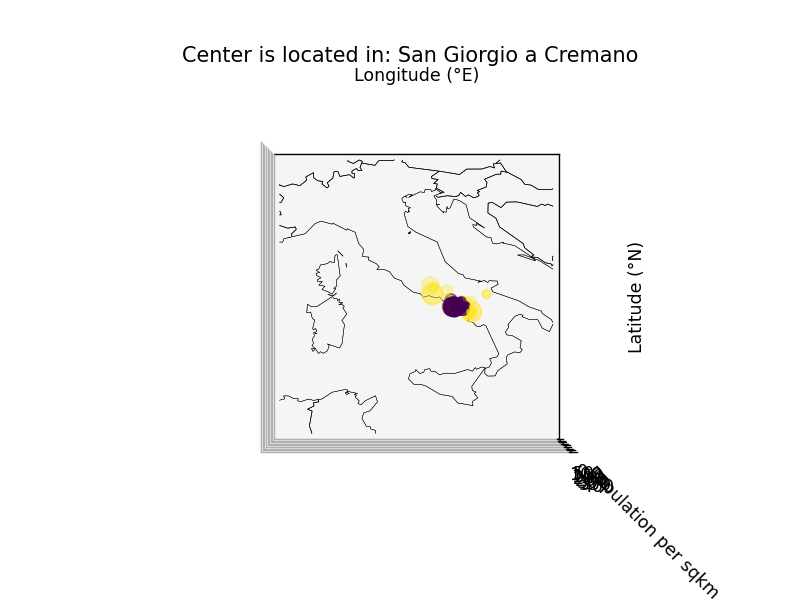

[[14.54491648 40.63798358]
 [14.54491648 40.63798358]
 [14.81982895 40.88916045]
 [14.81982895 40.88916045]
 [14.56140691 41.06632744]
 [14.56140691 41.06632744]
 [14.56140691 41.06632744]
 [13.34210735 41.72647125]
 [14.60521014 40.63424015]
 [14.60521014 40.63424015]
 [14.60521014 40.63424015]
 [14.60521014 40.63424015]
 [14.21653675 40.55142386]
 [14.21653675 40.55142386]
 [14.21653675 40.55142386]
 [14.21653675 40.55142386]
 [14.21653675 40.55142386]
 [14.55176809 41.03685746]
 [14.55176809 41.03685746]
 [14.83665185 40.91799979]
 [14.83665185 40.91799979]
 [14.83665185 40.91799979]
 [14.83665185 40.91799979]
 [14.83665185 40.91799979]
 [14.20627126 40.9730782 ]
 [14.20627126 40.9730782 ]
 [14.20627126 40.9730782 ]
 [14.20627126 40.9730782 ]
 [14.20627126 40.9730782 ]
 [14.20627126 40.9730782 ]
 [14.07840386 40.79708543]
 [14.07840386 40.79708543]
 [14.07840386 40.79708543]
 [14.07840386 40.79708543]
 [14.07840386 40.79708543]
 [14.61712905 40.95141659]
 [14.61712905 40.95141659]
 

Center is located in: San Giorgio a Cremano
maschi nubile/celibe Teen 14562 2.67 84


In [20]:
# for i in range (0, 4):
#     # Extract the data we're interested in
#     lat = df.loc[df["cluster"] == i]['lat'].values
#     lon = df.loc[df["cluster"] == i]['lng'].values
#     population = df.loc[df["cluster"] == i]['Value'].values
#     populationsqm = df.loc[df["cluster"] == i]['populPerKm2'].values
#     area = df.loc[df["cluster"] == i]['Size km2'].values
fig = plt.figure(0)
ax = fig.add_subplot(projection='3d')
# print(clusterNames[selectedCluster])

llcrnrlat = 35.5#44
urcrnrlat = 47
llcrnrlon = 7#7
urcrnrlon = 18.5#12
# Create a basemap instance that draws the Earth layer
bm = Basemap(llcrnrlat=llcrnrlat, llcrnrlon=llcrnrlon, 
            urcrnrlat=urcrnrlat, urcrnrlon=urcrnrlon,
            projection='cyl', resolution='l', fix_aspect=False, ax=ax)
# Add Basemap to the figure
ax.add_collection3d(bm.drawcoastlines(linewidth=0.25))
ax.add_collection3d(bm.drawcountries(linewidth=0.35))
ax.view_init(azim=-90, elev=90)
ax.set_xlabel('Longitude (°E)', labelpad=20)
ax.set_ylabel('Latitude (°N)', labelpad=20)
ax.set_zlabel('Population per sqkm', labelpad=20)
ax.set_zlim(0., 400)

colormap = np.arange(0,15)

from sklearn.ensemble import IsolationForest

clf = IsolationForest( random_state=0).fit_predict(np.array((lon,lat)).T)#Schema a blochi pptx
print(np.array((lon,lat)).T)

lonC, latC = calculateWeightedMean(lat, lon, populationsqm)
p = ax.scatter(lon, lat, (populationsqm), picker = True, s = area,c=colormap[clf])#Points # c=colormap[categories]
centers = ax.scatter(xs=lonC, ys=latC, edgecolor='black', c='white', marker = '*')#Centers

circle = kmRadius((lonC,latC))
r = ax.scatter(xs=circle[:,0], ys=circle[:,1], c='black', marker = '1')#Radius

closest = closest_point((lonC,latC), list(zip(lon, lat)))#Get closest point from picked

tx = 'Center is located in: %s' % (df.loc[(df["lng"] == closest[0])&
                                          (df["cluster"] == selectedCluster)&
                                          (df["lat"] == closest[1])]["Territorio"].values[0])
ax.set_title(tx)
print(tx)
cid = fig.canvas.mpl_connect('button_press_event', onclick)#Get mouse click

fig.show
print(clusterNames[selectedCluster])

In [ ]:
df.loc[(df["cluster"] == selectedCluster) & (df["Territorio"] == "Cusano Milanino")]

In [ ]:
# df.loc[(df["cluster"] == selectedCluster) & (df["Territorio"] == "Lecco")]

## PCA no categorical

### Graph num of components

Variance remained 1.0


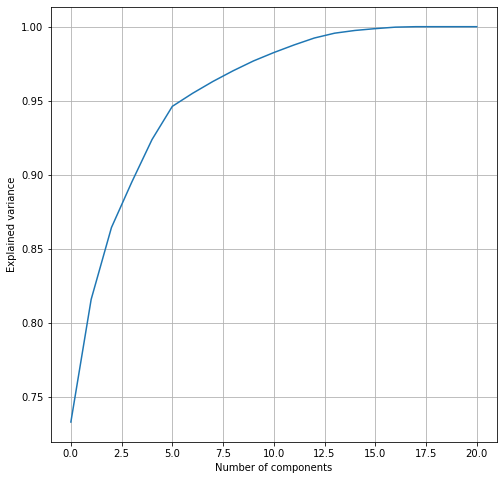

In [19]:
from sklearn.decomposition import PCA
%matplotlib inline
pca = PCA(n_components=21, random_state = 0)
principalComponents = pca.fit_transform(dfSlicedNoCat)
principalDf = pd.DataFrame(data = principalComponents)
print("Variance remained", np.sum(pca.explained_variance_ratio_))
#% of info contained with n components
plt.figure(figsize = (8,8))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.grid()

plt.savefig("Elbow_PCA.png")
# plt.show()

### 2 components

In [27]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state = 0)
principalComponents = pca.fit_transform(dfSlicedNoCat)
principalDf = pd.DataFrame(data = principalComponents)
print("Info remained with 2 components:", np.sum(pca.explained_variance_ratio_))
#% of info contained with n components

Info remained with 2 components: 0.8158580025670681


<IPython.core.display.Javascript object>


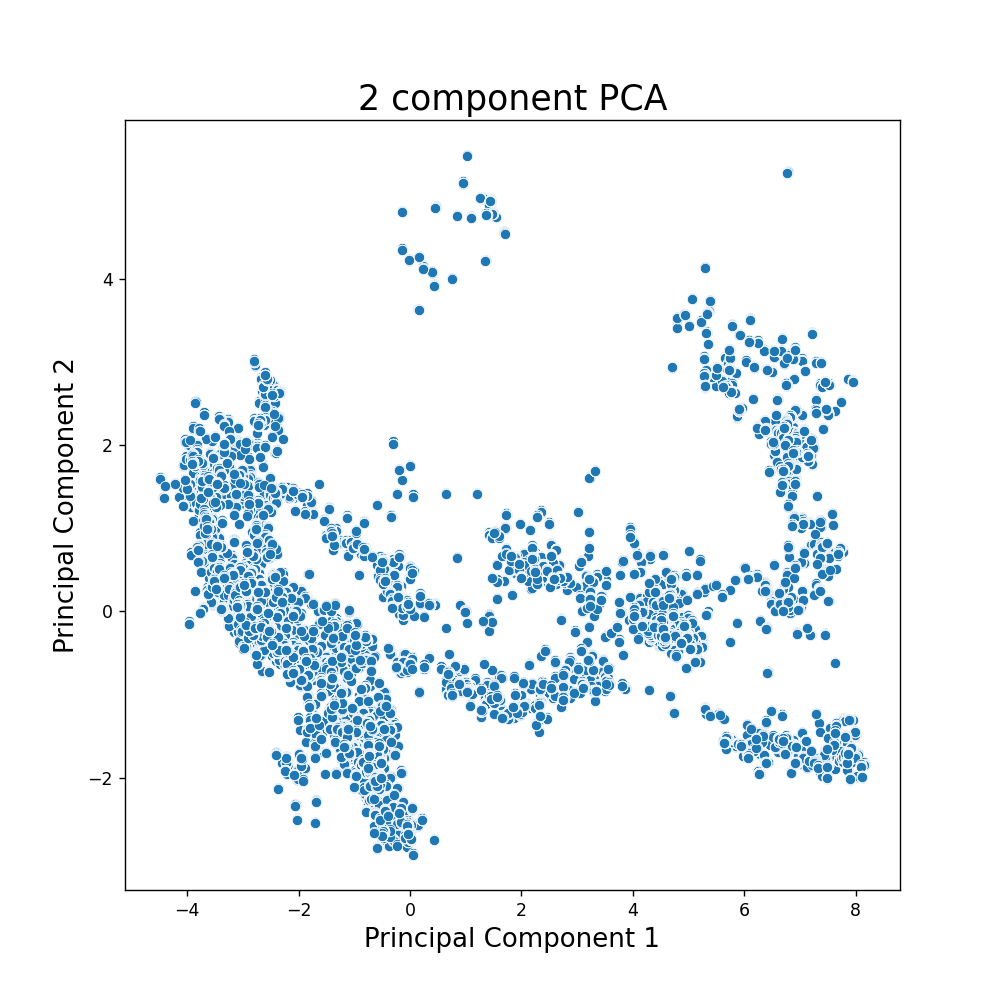

Text(0.5, 1.0, '2 component PCA')

In [110]:
plt.figure(figsize = (8,8))
sns.scatterplot(x = principalComponents[:,0], y = principalComponents[:,1]) 
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 component PCA', fontsize = 20)

### 3 components

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, random_state = 0)
principalComponents = pca.fit_transform(dfSlicedNoCat)
principalDf = pd.DataFrame(data = principalComponents)
print("Info remained with 3 components:", np.sum(pca.explained_variance_ratio_))
#% of info contained with n components

Info remained with 3 components: 0.8643817302539849


<IPython.core.display.Javascript object>


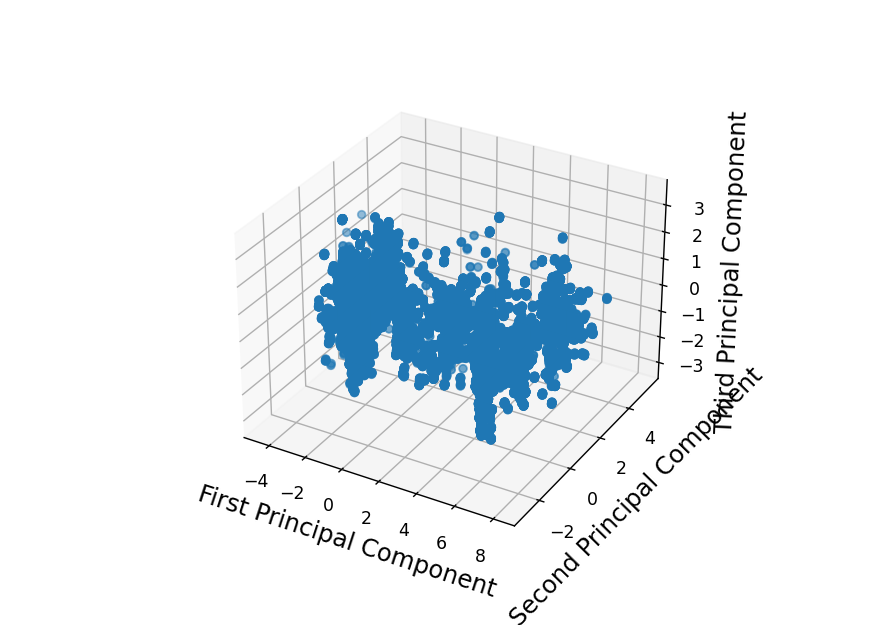

In [114]:
Xax = principalComponents[:,0]
Yax = principalComponents[:,1]
Zax = principalComponents[:,2]

cdict = {0:'red',1:'green'}
labl = {0:'Malignant',1:'Benign'}
marker = {0:'*',1:'o'}
alpha = {0:.3, 1:.5}

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

fig.patch.set_facecolor('white')
ax.scatter(Xax, Yax, Zax)
# for loop ends
ax.set_xlabel("First Principal Component", fontsize=14)
ax.set_ylabel("Second Principal Component", fontsize=14)
ax.set_zlabel("Third Principal Component", fontsize=14)

plt.show()

## FAMD (PCA  + categorical)

### Graph num of components

Variance remained 1.0


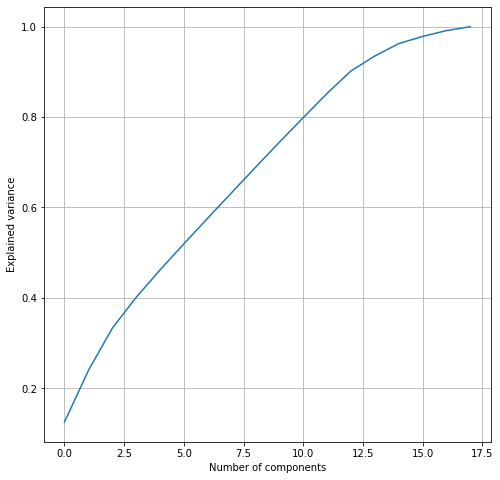

In [23]:
import prince

famd = prince.FAMD(
     n_components=18,
     n_iter = 3,
     engine='auto',
     random_state=0
)
famd = famd.fit(dfSliced)
famdTr = famd.transform(dfSliced)
print("Variance remained",np.sum(famd.explained_inertia_))
plt.figure(figsize = (8,8))

plt.plot(np.cumsum(famd.explained_inertia_))
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.grid()

# plt.savefig("Elbow_FAMD.png")

### 2 components

Variance remained 0.23921587783468662


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


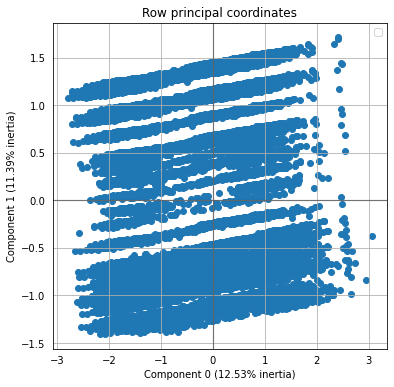

In [26]:
famd = prince.FAMD(
     n_components=2,
     n_iter = 3,
     engine='auto',
     random_state=0
)
famd = famd.fit(dfSliced)
famdTr = famd.transform(dfSliced)
print("Variance remained",np.sum(famd.explained_inertia_))

ax = famd.plot_row_coordinates(
     X = dfSliced,
     ax=None,
     figsize=(6, 6),
     x_component=0,
     y_component=1,
     ellipse_outline=True,
     ellipse_fill=True,
     show_points=True
)
# ax.get_figure().savefig('famd_row_coordinates.png')


## Compare clustering results

In [12]:
# CHScore = []# Higher better
# DBScore = []# 0 best
score = []# 1 best, -1 worst

In [17]:
# from sklearn.metrics.cluster import homogeneity_score
# from sklearn.metrics.cluster import adjusted_mutual_info_score
# from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import calinski_harabasz_score
from sklearn.metrics.cluster import davies_bouldin_score
from sklearn.metrics.cluster import silhouette_score

# homogeneity_score(kMeansCategories,Y)
# adjusted_mutual_info_score(kMeansCategories, [0, 0, 1, 1])
# adjusted_rand_score(kMeansCategories, [0, 0, 1, 1])
# calinski_harabasz_score (dfSlicedNoCat,kMeansCategories)
# davies_bouldin_score(dfSlicedNoCat,kMeansCategories)
# silhouette_score(dfSlicedNoCat,kMeansCategories,sample_size = int(len(dfSlicedNoCat)/5),random_state = 0) 

score.append(["KMeans with Elbow",
              calinski_harabasz_score (dfSlicedNoCat,kMeansCategories),
              davies_bouldin_score(dfSlicedNoCat,kMeansCategories),
              silhouette_score(dfSlicedNoCat,kMeansCategories,sample_size = int(len(dfSlicedNoCat)/5),random_state = 0),
              len(np.unique(kMeansCategories))])

score.append(["KPrototype with Elbow",
                calinski_harabasz_score (dfSlicedNoCat,KProtcategories),
                davies_bouldin_score(dfSlicedNoCat,KProtcategories),
              silhouette_score(dfSlicedNoCat,KProtcategories,sample_size = int(len(dfSliced)/5),random_state = 0),
            len(np.unique(KProtcategories))])

score.append(["Xmeans",calinski_harabasz_score (dfSlicedNoCat,xmeansCategories),
              davies_bouldin_score(dfSlicedNoCat,xmeansCategories),
              silhouette_score(dfSlicedNoCat,xmeansCategories,sample_size = int(len(dfSlicedNoCat)/5),random_state = 0),
             len(np.unique(xmeansCategories))])

score.append(["SOM",calinski_harabasz_score (dfSlicedNoCat,SOMCategories),
              davies_bouldin_score(dfSlicedNoCat,SOMCategories),
              silhouette_score(dfSlicedNoCat,SOMCategories,sample_size = int(len(dfSlicedNoCat)/5),random_state = 0),
            len(np.unique(SOMCategories))])

score.append(["HDBSCAN",calinski_harabasz_score (dfSlicedNoCat,hdbCategories),
              davies_bouldin_score(dfSlicedNoCat,hdbCategories),
              hdbscan.validity.validity_index(dfSlicedNoCat.values,hdbCategories, metric = 'euclidean'),
             len(np.unique(hdbCategories))])

score.append(["FCM",calinski_harabasz_score (dfSlicedNoCat,FCMCategories),
              davies_bouldin_score(dfSlicedNoCat,FCMCategories),
              silhouette_score(dfSlicedNoCat,FCMCategories,sample_size = int(len(dfSlicedNoCat)/5),random_state = 0),
             len(np.unique(FCMCategories))])


In [18]:
pd.DataFrame(score, columns = ['Algorithm', 'CH Value(higher better)','DB Value(0 best)', 'Silhouette value(1 best)', 'Number of clusters'])

,Algorithm,CH Value(higher better),DB Value(0 best),Silhouette value(1 best)
0,KPrototype with Elbow,31552.476139,3.326525,0.080785
